In [1]:
import pandas as pd
import numpy as np
import gc

In [2]:
# This is the DB I've been scrapping from biobiochile.cl
df_articles = pd.read_csv('./article_202310072058.csv', delimiter=';')
df_articles.head()

,article_hash,article_title,category,publish_date,article_body,raw_content,source_entity,article_link,generated_summary,negative_score,importance_score
0,cfca211bf39221671436397b140ea57a7a9268851dfef8...,Solicitan la caducidad de 166 concesiones acuí...,Nacional,2023-07-17 23:54:00.000,La región de Los Lagos es una de las regiones ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
1,de051d5444e79470f618b38588ea5988ce808ee1db192d...,Lota: Bomberos descarta que auto estacionado e...,Nacional,2023-07-17 23:10:00.000,Una camioneta se estacionó justo a la salida d...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
2,39dff9b324fe3fb40b70d8a25651e95d57e015ea274865...,Declaran emergencia ambiental para este martes...,Nacional,2023-07-17 23:02:00.000,La Delegación presidencial declaró emergencia ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
3,f4001720cfe06f5c0aa36c3d8b83bd25a2b8bad50e14c4...,Estudio revela preocupante aumento de tercera ...,Nacional,2023-07-17 21:58:00.000,Una de las razones de este aumento podría ser ...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN
4,8212613c7830f1466362f2dfc412c5675cde6376b752df...,"Denuncia de ""malos olores"": Municipalidad de Q...",Nacional,2023-07-17 21:18:00.000,La Municipalidad de Quilicura reportó la noche...,\n \n\n ...,biobiochile.cl,https://www.biobiochile.cl/noticias/nacional/r...,NaN,NaN,NaN


In [15]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5741 entries, 0 to 5740
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   article_hash       5741 non-null   object 
 1   article_title      5741 non-null   object 
 2   category           5741 non-null   object 
 3   publish_date       5741 non-null   object 
 4   article_body       5687 non-null   object 
 5   raw_content        5688 non-null   object 
 6   source_entity      5741 non-null   object 
 7   article_link       5741 non-null   object 
 8   generated_summary  0 non-null      float64
 9   negative_score     0 non-null      float64
 10  importance_score   0 non-null      float64
dtypes: float64(3), object(8)
memory usage: 493.5+ KB


In [3]:
df_articles = df_articles.drop(index=df_articles[df_articles['article_body'].isnull() == True].index)

In [4]:
print('Average title length: ', int(np.average(df_articles['article_title'].str.len())))
print('Minimum title length: ', int(np.min(df_articles['article_title'].str.len())))
print('Maximum title length: ', int(np.max(df_articles['article_title'].str.len())))

Average title length:  93
Minimum title length:  38
Maximum title length:  102


In [5]:
print('Average body length: ', int(np.average(df_articles['article_body'].str.len())))
print('Minimum body length: ', int(np.min(df_articles['article_body'].str.len())))
print('Maximum body length: ', int(np.max(df_articles['article_body'].str.len())))

Average body length:  2141
Minimum body length:  15
Maximum body length:  31870


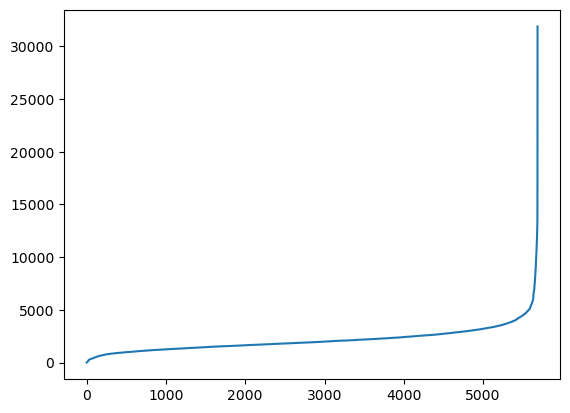

In [37]:
body_len = df_articles['article_body'].str.len()
body_len = body_len.sort_values()
body_len.reset_index(inplace=True, drop=True)
body_len.plot();

In [42]:
# Store news with body with a minimum of 250~300 characters
print(df_articles[(df_articles['article_body'].str.len() >= 0) & (df_articles['article_body'].str.len() <= 250)]['article_body'].values)

[' PRESENTACIÓN SUBALTERNOS “LA CHINA” LA CASA DE TORTURA EXPLOTACIÓN SEXUAL LA AMENAZA BAJA EN HOMICIDIOS'
 ' VEA DOCUMENTO:'
 ' Región de Valparaíso La noche de este jueves, un voraz incendio está afectando a unos locales comerciales de Limache, en la región de Valparaíso. Radio Bío Bío informó que hay peligro de propagación.'
 ' “PUEDE GUARDAR SILENCIO” “USTED TIENE QUE OLVIDAR” “ME DIJO QUE NO HABLARA” UNA VISITA INCÓMODA Radio Bío Bío intentó obtener una versión de Camila Polizzi, sin respuesta hasta el cierre de esta edición.'
 ' RIESGO CALCULADO UN ALCALDE AMIGO'
 ' KIMÚN ENTRA EN EL RADAR EL MECANISMO CHINQUIHUE, KIMÚN, PARTICIPA INCUMPLIMIENTOS, DESPROLIJIDADES Y ACUSACIONES CRUZADAS LA GANGA FOLLOW THE MONEY ¿Y AHORA, QUÉ?'
 ' Nacional La embajadora chilena en Reino Unido, Susana Herrera, presentó su renuncia tras el polémico proyecto que impulsó en la región del Bío Bío.'
 ' Región Metropolitana El periodista Pablo Mackenna quedó en prisión preventiva tras protagonizar un ac

In [14]:
print(df_articles[(df_articles['article_body'].str.len() >= 5000) & (df_articles['article_body'].str.len() <= 5100)]['article_link'].values)

['https://www.biobiochile.cl/noticias/nacional/chile/2023/07/18/delincuencia-callejera-y-distrubios-eeuu-emite-alerta-a-quienes-quieran-viajar-a-chile.shtml'
 'https://www.biobiochile.cl/noticias/nacional/region-metropolitana/2023/07/18/contraloria-formula-cargos-contra-jadue-faltas-a-la-probidad-en-sumario-a-farmacias-populares.shtml'
 'https://www.biobiochile.cl/noticias/nacional/chile/2023/08/23/hija-del-asesinado-general-carlos-prats-duele-que-aun-piensen-que-el-golpe-tuvo-sentido.shtml'
 'https://www.biobiochile.cl/noticias/nacional/chile/2023/08/01/parece-una-lista-de-supermercado-las-criticas-de-la-oposicion-al-anuncio-del-pacto-fiscal.shtml'
 'https://www.biobiochile.cl/noticias/nacional/region-de-magallanes/2023/08/10/consejero-regional-denuncia-irregularidades-en-fundacion-de-punta-arenas-tras-recibir-aportes-del-gore.shtml'
 'https://www.biobiochile.cl/noticias/nacional/chile/2023/08/22/estudio-revelo-que-habilidades-socioemocionales-son-el-desafio-central-en-la-formacion-in

In [45]:
print(df_articles[(df_articles['article_body'].str.len() >= 7000) & (df_articles['article_body'].str.len() <= 10000)]['article_link'].values)

['https://www.biobiochile.cl/noticias/nacional/chile/2023/07/18/conmocion-por-muerte-de-nina-de-13-anos-victima-de-bullying-en-colegio-de-la-serena.shtml'
 'https://www.biobiochile.cl/noticias/economia/negocios-y-empresas/2023/07/27/constructora-pacal-deudas-denuncias-y-solicitudes-de-liquidacion-que-marcan-la-crisis-de-la-empresa.shtml'
 'https://www.biobiochile.cl/noticias/nacional/chile/2023/07/31/cplt-propone-27-reformas-protransparencia-y-probidad-al-ejecutivo-y-al-legislativo.shtml'
 'https://www.biobiochile.cl/noticias/nacional/chile/2023/08/05/la-espuma-del-partido-republicano-y-su-plan-para-no-desvanecerse.shtml'
 'https://www.biobiochile.cl/noticias/nacional/chile/2023/08/05/pelea-toxica-la-brecha-que-se-abrio-en-el-partido-socialista-tras-escandalo-de-fundaciones.shtml'
 'https://www.biobiochile.cl/noticias/nacional/chile/2023/07/29/el-partido-de-la-gente-esta-en-peligro-de-extincion.shtml'
 'https://www.biobiochile.cl/noticias/nacional/region-de-coquimbo/2023/08/24/la-ardua

In [15]:
import torch
from transformers import BertTokenizerFast, EncoderDecoderModel
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ckpt = 'mrm8488/bert2bert_shared-spanish-finetuned-summarization'
tokenizer = BertTokenizerFast.from_pretrained(ckpt)
model = EncoderDecoderModel.from_pretrained(ckpt).to(device)

The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


In [16]:
def generate_summary(text):
   inputs = tokenizer([text], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
   input_ids = inputs.input_ids.to(device)
   attention_mask = inputs.attention_mask.to(device)
   output = model.generate(input_ids, attention_mask=attention_mask)
   return tokenizer.decode(output[0], skip_special_tokens=True)

In [17]:
device

'cuda'

<AxesSubplot: >

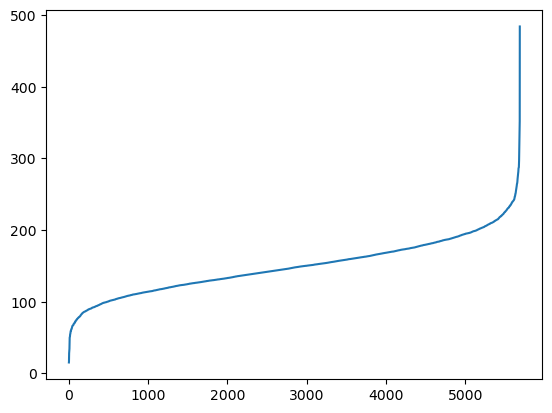

In [104]:
# Average chunk splitted by dot length
splits = df_articles['article_body'].str.split('.')
average_lengths = splits.apply(lambda x: sum(len(item) for item in x) / len(x) if len(x) > 0 else 0)
plotsplits = average_lengths.sort_values().reset_index(drop=True)
plotsplits.plot()

In [18]:
def getChunks(article):
    parts = article.split('.')
    df = pd.DataFrame(parts)
    df.columns = ['article_parts']
    df = df[df['article_parts'].str.len() > 0]
    return df.to_numpy().squeeze()

In [125]:
def mergeChunks(number, chunks):
    # Merge the chunks into workable lengths ~390
    # The purpose of this is to generate shorter summaries of about 3~4 bulletpoints
    results = []
    acc = []
    try:
        for c in chunks:
            txt = c.strip()
            if (len('. '.join(acc)) + len(txt)) >= number:
                results.append('. '.join(acc.copy()))
                acc.clear()
            acc.append(txt)  # Always add the current chunk to acc
        # Add any remaining text in acc to results
        if acc:
            results.append('. '.join(acc))
    except Exception as e:
        print(e)
    return results

In [167]:
article = df_articles[(df_articles['article_body'].str.len() >= 7000) & (df_articles['article_body'].str.len() <= 10000)].sample(1)
print('Title:', article['article_title'].values[0])
print('Body:', article['article_body'].values[0])
article_body = article['article_body'].values[0]
print('Optimal length: ~', int(len(article_body)/390), 'chunks') # About 390 length recommended for summarizer
print(article_body)

Title: Nuevo Cesfam: auditoría de alcaldesa de Las Condes es cuestionada por Dirección de Control municipal
Body: El día 19 de junio se conoció el resultado de la auditoría encargada por Daniela Peñaloza, alcaldesa de la comuna de Las Condes, a la firma AZ, para investigar el proceso de adquisición de inmuebles para que fuera construido un nuevo Cesfam, después de que cinco concejales denunciaran irregularidades en este proceso. Región Metropolitana El día 19 de junio, el resultado de la auditoría externa encargada por la alcaldesa de Las Condes, Daniela Peñaloza (UDI), a la firma de AZ, para que se investigara el proceso de adquisición de inmuebles para la construcción de un nuevo Cesfam, después de que cinco concejales denunciaran irregularidades en este proceso. Una de las conclusiones de esta investigación interna es que se indicó que existieron “errores administrativos”, pero no hubo delitos. Sin embargo, actualmente ese documento está en el centro de los cuestionamientos de los e

In [168]:
chunks = getChunks(article_body)
print('Total chunks: \t\t', len(chunks))
merged_chunks = mergeChunks(390*2, chunks)
print('Optimal chunks: \t', f'{(len(article_body)/(390*2)):0.2f}')
print('Result chunks: \t\t', len(merged_chunks))

merged_chunks[0]

Total chunks: 		 45
Optimal chunks: 	 11.48
Result chunks: 		 14


'El día 19 de junio se conoció el resultado de la auditoría encargada por Daniela Peñaloza, alcaldesa de la comuna de Las Condes, a la firma AZ, para investigar el proceso de adquisición de inmuebles para que fuera construido un nuevo Cesfam, después de que cinco concejales denunciaran irregularidades en este proceso. Región Metropolitana El día 19 de junio, el resultado de la auditoría externa encargada por la alcaldesa de Las Condes, Daniela Peñaloza (UDI), a la firma de AZ, para que se investigara el proceso de adquisición de inmuebles para la construcción de un nuevo Cesfam, después de que cinco concejales denunciaran irregularidades en este proceso'

In [169]:
for i in range(len(merged_chunks)):
    merged_chunks[i] = merged_chunks[i] + '.'
    merged_chunks[i] = merged_chunks[i].strip()

In [170]:
merged_chunks[0]

'El día 19 de junio se conoció el resultado de la auditoría encargada por Daniela Peñaloza, alcaldesa de la comuna de Las Condes, a la firma AZ, para investigar el proceso de adquisición de inmuebles para que fuera construido un nuevo Cesfam, después de que cinco concejales denunciaran irregularidades en este proceso. Región Metropolitana El día 19 de junio, el resultado de la auditoría externa encargada por la alcaldesa de Las Condes, Daniela Peñaloza (UDI), a la firma de AZ, para que se investigara el proceso de adquisición de inmuebles para la construcción de un nuevo Cesfam, después de que cinco concejales denunciaran irregularidades en este proceso.'

In [171]:
%%time
summaries_1 = []
for mc in merged_chunks:
    smm = generate_summary(mc)
    summaries_1.append(smm)
    print(smm)

/home/stare/anaconda3/envs/test-env/lib/python3.8/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Cinco concejales denunciaron irregularidades en el proceso de adquisición de inmuebles para que fuera construido un nuevo Cesfam
La dirección de control municipal detectó varias deficiencias en el proceso de contratación de los servicios y también en el contenido de la evaluación realizada por el concejal Sergio Melnick
Contraloría, del Ministerio Público, no tiene timbre que lo haga atribuible a la firma
La empresa Albagli Zaliasnik y AZ se quejan de que el informe no ha sido firmado en ninguna de las hojas que lo componen, para los estándares municipales
La empresa contrataba única y exclusivamente al primer estudio diferente al contratado
La investigación estableció errores administrativos claros, los cuales podrían establecer la responsabilidad tanto del propio director de Control y de Secplan
El informe señala que en medio del trabajo de AZ, se incluyen lo que constituirían a nuestro juicio imprecisiones, errores y desconocimiento del funcionamiento de un municipio, circunstancias

In [145]:
merged_chunks_2 = mergeChunks(390, summaries_1)
merged_chunks_2

['Miles de familias vieron el sueño de la casa propia truncado por la negligencia de la Constructora Pacal, que acumula una serie de reclamos y denuncias. La constructora Pacal tiene diversos proyectos inmobiliarios inmobiliarios, pero en su mayoría, las casas pueden ser adquiridas mediante subsidios estatales',
 'El Servicio Nacional del Consumidor ( Sernac ) cuenta con una herramienta para conocer el comportamiento de las empresas y cómo responden a los reclamos. La entrega, que estaba dispuesta para el primer trimestre del 2022, fue vista a BioBioChile en abril del 2020. El periodista de EL PAÍS analiza las declaraciones de los candidatos presidenciales a la presidencia del país',
 'La afectada, afectada por la muerte de la afectada, recuerda que la fecha ya ha transcurrido, les ha escrito y nada, sigue sin pasar nada. Un hecho similar le ocurrió a Valentina Balboa, quien en 2020 realizó la reserva de una vivienda, pero desistió de la compra.',
 'Valentina sí recibió el reembolso. Y

In [147]:
%%time
summaries_2 = []
for mc in merged_chunks_2:
    smm = generate_summary(mc)
    summaries_2.append(smm)
    print(smm)

/home/stare/anaconda3/envs/test-env/lib/python3.8/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Miles de familias vieron el sueño de la casa propia truncado por la negligencia de Pacal, que acumula una serie de reclamos y denuncias. La constructora Pacal tiene diversos proyectos inmobiliarios, pero en su mayoría, las casas pueden ser adquiridas mediante subsidios estatales
El periodista de EL PAÍS analiza las declaraciones de los candidatos presidenciales a la presidencia del país
La afectada recuerda que la fecha ya ha transcurrido, les ha escrito y nada, sigue sin pasar nada
Valentina sí recibió el reembolso. Yo entregué este ahorro de 80 UF en diciembre del 2020. En noviembre del 2021 renuncié y no fui hasta junio del 2022. Los afectados denuncian el abandono de proyectos por parte de la constructora. En la comuna de San Fernando, el proyecto Mirador
Las viviendas han sido foco de delincuencia, y además acusan de posibles tomas irregulares. La mayor constructora con subsidios de vivienda Lo increíble de las denuncias que se pueden encontrar en diversas regiones del país
Según 

In [155]:
%%time
smm = generate_summary(merged_chunks_2[0])
print(smm)

Miles de familias vieron el sueño de la casa propia truncado por la negligencia de Pacal, que acumula una serie de reclamos y denuncias. La constructora Pacal tiene diversos proyectos inmobiliarios, pero en su mayoría, las casas pueden ser adquiridas mediante subsidios estatales
CPU times: user 703 ms, sys: 23.7 ms, total: 727 ms
Wall time: 726 ms


In [148]:
merged_chunks_3 = mergeChunks(390, summaries_2)
merged_chunks_3

['Miles de familias vieron el sueño de la casa propia truncado por la negligencia de Pacal, que acumula una serie de reclamos y denuncias. La constructora Pacal tiene diversos proyectos inmobiliarios, pero en su mayoría, las casas pueden ser adquiridas mediante subsidios estatales. El periodista de EL PAÍS analiza las declaraciones de los candidatos presidenciales a la presidencia del país',
 'La afectada recuerda que la fecha ya ha transcurrido, les ha escrito y nada, sigue sin pasar nada. Valentina sí recibió el reembolso. Yo entregué este ahorro de 80 UF en diciembre del 2020. En noviembre del 2021 renuncié y no fui hasta junio del 2022. Los afectados denuncian el abandono de proyectos por parte de la constructora. En la comuna de San Fernando, el proyecto Mirador',
 'Las viviendas han sido foco de delincuencia, y además acusan de posibles tomas irregulares. La mayor constructora con subsidios de vivienda Lo increíble de las denuncias que se pueden encontrar en diversas regiones del

In [151]:
%%time
smm = generate_summary('. '.join(merged_chunks_3))
print(smm)

/home/stare/anaconda3/envs/test-env/lib/python3.8/site-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


El periodista de EL PAÍS analiza las declaraciones de los candidatos presidenciales a la presidencia del país
CPU times: user 304 ms, sys: 24 ms, total: 328 ms
Wall time: 328 ms


In [141]:
# Testing merging the summaries to further compact summaries as an attempt to reduce some problems
if len(summaries_1) % 2 == 0:
    merged_summaries_1 = [summaries_1[i] + '. ' + summaries_1[i+1] for i in range(0, len(summaries_1), 2)]
else:
    merged_summaries_1 = [summaries_1[i] + '. ' + summaries_1[i+1] for i in range(0, len(summaries_1)-1, 2)]
    merged_summaries_1.append(summaries_1[-1])
merged_summaries_1

['Miles de familias vieron el sueño de la casa propia truncado por la negligencia de la Constructora Pacal, que acumula una serie de reclamos y denuncias. La constructora Pacal tiene diversos proyectos inmobiliarios inmobiliarios, pero en su mayoría, las casas pueden ser adquiridas mediante subsidios estatales',
 'El Servicio Nacional del Consumidor ( Sernac ) cuenta con una herramienta para conocer el comportamiento de las empresas y cómo responden a los reclamos. La entrega, que estaba dispuesta para el primer trimestre del 2022, fue vista a BioBioChile en abril del 2020',
 'El periodista de EL PAÍS analiza las declaraciones de los candidatos presidenciales a la presidencia del país. La afectada, afectada por la muerte de la afectada, recuerda que la fecha ya ha transcurrido, les ha escrito y nada, sigue sin pasar nada',
 'Un hecho similar le ocurrió a Valentina Balboa, quien en 2020 realizó la reserva de una vivienda, pero desistió de la compra.. Valentina sí recibió el reembolso. Y

In [142]:
%%time
summaries_1_merged = []
for mc in merged_summaries_1:
    smm = generate_summary(mc)
    summaries_1_merged.append(smm)
    print(smm)

Miles de familias vieron el sueño de la casa propia truncado por la negligencia de Pacal, que acumula una serie de reclamos y denuncias. La constructora Pacal tiene diversos proyectos inmobiliarios, pero en su mayoría, las casas pueden ser adquiridas mediante subsidios estatales
El Servicio Nacional del Consumidor cuenta con una herramienta para conocer el comportamiento de las empresas y cómo responden a los reclamos
El periodista de EL PAÍS analiza las declaraciones de los candidatos presidenciales a la presidencia del país
Valentina Balboa, quien en 2020 realizó la reserva de una vivienda, desistió de la compra. Yo entregué este ahorro de 80 UF en diciembre del 2020. En noviembre del 2021 renuncié y no fui hasta junio del 2022 renuncié
En la comuna de San Fernando, el proyecto Mirador Alameda da la impresión de ser un sitio olvidado, lleno de escombros y sin personal ni maquinarias
Las viviendas han sido foco de delincuencia, y además acusan de posibles tomas irregulares. La mayor c

In [163]:
!sudo apt install libenchant1c2a -y

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libenchant1c2a is already the newest version (1.6.0-11.3build1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [30]:
!pip install pyenchant

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [39]:
!sudo apt install myspell-es

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  hunspell libreoffice-core | openoffice.org-hunspell | openoffice.org-core
  iceape-browser | iceweasel | icedove
The following NEW packages will be installed:
  myspell-es
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 201 kB of archives.
After this operation, 1004 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 myspell-es all 1.11-15 [201 kB]
Fetched 201 kB in 0s (2459 kB/s)   

78Selecting previously unselected package myspell-es.
(Reading database ... 108068 files a

In [43]:
import enchant

print(enchant.list_languages())

d = enchant.Dict('es_CL')

def checkDict(word):
    return d.check(word)

['en', 'en_AU', 'en_CA', 'en_GB', 'en_US', 'es_ES', 'es_DO', 'es_SV', 'es_NI', 'es_CR', 'es_PE', 'es_GT', 'es_CL', 'es_PR', 'es_CU', 'es_PY', 'es', 'es_VE', 'es_PA', 'es_HN', 'es_UY', 'es_MX', 'es_AR', 'es_BO', 'es_EC', 'es_CO']


In [85]:
import nltk
from nltk.metrics.distance import edit_distance

nltk.download('punkt')  # Download necessary NLTK data

def most_similar_word(target_word, text):
    words = nltk.word_tokenize(text)
    most_similar = None
    min_distance = float('inf')
    
    for word in words:
        distance = edit_distance(target_word, word)
        if distance < min_distance:
            min_distance = distance
            most_similar = word
    return most_similar

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [86]:
merged_summaries_1

['Un accidente de tránsito múltiple en el camino entre Concepción y Chiguayante generó una gran congestión vehicular de más de 4 kilómetros en la capital del Bío Bío. Un conductor que se dirigía de sur a norte perdió el control de su vehículo y cruzó el bandejón central, impactando a un segundo móvil',
 'El jefe comunal chintino asegura que el causante del accidente se había dormido al volante. La víctima de un número indeterminado de lesionados, sin especificar tampoco la cuantía de las lesiones, ha sido dada de alta en el hospital']

In [87]:
whole_article

'Ante el cierre del camino entre ambas comunas, el tránsito fue desviado hacia avenida Costanera para viajar desde Concepción a Chiguayante. Región del Bío Bío Un accidente de tránsito múltiple en el camino entre Concepción y Chiguayante generó una importante congestión vehicular de más de 4 kilómetros en la capital regional del Bío Bío, principalmente en el sector Pedro de Valdivia. Según información preliminar, entregada por el alcalde de Chiguayante, Antonio Rivas, el choque en el sector Lonco, se habría originado luego de que un conductor que se dirigía de sur a norte, perdiera el control de su vehículo y cruzara el bandejón central, impactando a un segundo móvil. Luego, un tercer auto colisionó por alcance, dejando la calzada con el tránsito limitado. Es más, el jefe comunal chiguayantino aseguró que el causante del accidente se habría dormido al volante. “Uno de los conductores se quedó dormido y atravesó el eje central de la calzada y esto provocó un choque entre tres vehículos 

In [102]:
# Fixing weird words that the model generates trying to make summaries of weird Chilean words, and improve quality of generated summaries

import re

def replaceWeirdSummaries(whole_article, summaries):
    cleaned_article = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', whole_article)

    parts_text = cleaned_article.split(' ')

    rare_words = []

    for p in parts_text:
        if len(p) == 0:
            continue
        if checkDict(p) == False:
            rare_words.append(p)

    for i in range(len(summaries)):
        cleaned_summary = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', summaries[i])
        result = ''
        for t in cleaned_summary.split(' '):
            if t.lower() not in cleaned_article.lower() and  checkDict(t) == False:
                w = most_similar_word(t, ' '.join(rare_words))
                print(t, w)
                summaries[i] = str(summaries[i]).replace(t, w)
    print(summaries)
    
replaceWeirdSummaries(whole_article, summaries_1)

chintino chiguayantino
['Un accidente de tránsito múltiple en el camino entre Concepción y Chiguayante generó una gran congestión vehicular de más de 4 kilómetros en la capital del Bío Bío', 'Un conductor que se dirigía de sur a norte perdió el control de su vehículo y cruzó el bandejón central, impactando a un segundo móvil', 'El jefe comunal chiguayantino asegura que el causante del accidente se había dormido al volante', 'La víctima de un número indeterminado de lesionados, sin especificar tampoco la cuantía de las lesiones, ha sido dada de alta en el hospital']


In [108]:
summaries_1

['Un accidente de tránsito múltiple en el camino entre Concepción y Chiguayante generó una gran congestión vehicular de más de 4 kilómetros en la capital del Bío Bío',
 'Un conductor que se dirigía de sur a norte perdió el control de su vehículo y cruzó el bandejón central, impactando a un segundo móvil',
 'El jefe comunal chiguayantino asegura que el causante del accidente se había dormido al volante',
 'La víctima de un número indeterminado de lesionados, sin especificar tampoco la cuantía de las lesiones, ha sido dada de alta en el hospital']

### Evaluate Models

In [20]:
!pip install absl-py nltk six>=1.14
!pip install rouge-score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=a78db118a0f0f896f6cbbea0ab6ba81942be675c5e6a81afeab21e6afb84be8c
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [104]:
def evaluateModel(reference, summaries):
    from rouge_score import rouge_scorer
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = []
    for i in range(len(summaries)):
        score = rouge.score(reference[i], summaries[i])
        scores.append(score)
    return scores

In [105]:
scores_1 = evaluateModel(merged_chunks, summaries_1)

In [106]:
def printScores(scores):
    chunk=0
    for s in scores:
        chunk=chunk+1
        print('Chunk ', chunk)
        r1 = s['rouge1']
        print('scores:\t precision \t recall \t fmeasure')
        print(f'rouge1:\t {r1.precision:.5f} \t {r1.recall:.5f} \t {r1.fmeasure:.5f}')
        r2 = s['rougeL']
        print(f'rougeL:\t {r2.precision:.5f} \t {r2.recall:.5f} \t {r2.fmeasure:.5f}\n')
    

- "rouge1" considers the overlap of unigrams (individual words) between the generated text and reference text.
- "rougeL" is a longer matching measure that considers the longest common subsequence of words between the generated and reference text.

- "Precision" measures the proportion of the generated text that is relevant and matches the reference text. It's calculated as the number of correct matches divided by the total number of generated words.
- "Recall" measures the proportion of the reference text that is correctly captured by the generated text. It's calculated as the number of correct matches divided by the total number of reference words.
- "F-measure" is the harmonic mean of precision and recall and provides a balanced measure of both precision and recall. It's often used as an overall measure of the quality of the generated text.

Higher is better

In [107]:
printScores(scores_1)

Chunk  1
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.97222 	 0.47297 	 0.63636
rougeL:	 0.97222 	 0.47297 	 0.63636

Chunk  2
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.93103 	 0.38571 	 0.54545
rougeL:	 0.93103 	 0.38571 	 0.54545

Chunk  3
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.87500 	 0.24138 	 0.37838
rougeL:	 0.87500 	 0.24138 	 0.37838

Chunk  4
scores:	 precision 	 recall 	 fmeasure
rouge1:	 0.70370 	 0.41304 	 0.52055
rougeL:	 0.62963 	 0.36957 	 0.46575



In [109]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer_summ = AutoTokenizer.from_pretrained("edumunozsala/RuPERTa_base_sentiment_analysis_es")
model_summ = AutoModelForSequenceClassification.from_pretrained("edumunozsala/RuPERTa_base_sentiment_analysis_es")

In [132]:
def getSentimentScore(summaries):
    results = []
    for s in summaries:
        input_ids = torch.tensor(tokenizer_summ.encode(s)).unsqueeze(0)
        outputs = model_summ(input_ids)
        probabilities = torch.softmax(outputs.logits, dim=1)
        negative_sentiment_score = probabilities[0][0].item()
        positive_sentiment_score = probabilities[0][1].item()

        print(s)
        print("Scores: ", '-', negative_sentiment_score, '+',positive_sentiment_score)
        print()

In [133]:
getSentimentScore(summaries_1)

Un accidente de tránsito múltiple en el camino entre Concepción y Chiguayante generó una gran congestión vehicular de más de 4 kilómetros en la capital del Bío Bío
Scores:  - 0.010643890127539635 + 0.9893561005592346

Un conductor que se dirigía de sur a norte perdió el control de su vehículo y cruzó el bandejón central, impactando a un segundo móvil
Scores:  - 0.06757558137178421 + 0.9324243664741516

El jefe comunal chiguayantino asegura que el causante del accidente se había dormido al volante
Scores:  - 0.7908575534820557 + 0.20914246141910553

La víctima de un número indeterminado de lesionados, sin especificar tampoco la cuantía de las lesiones, ha sido dada de alta en el hospital
Scores:  - 0.03611600026488304 + 0.9638839960098267



In [167]:
import nltk
from nltk.corpus import stopwords

# Download the Spanish stop words list if you haven't already
nltk.download('stopwords')

def remove_stopwords(text):
    """
    Remove stop words from a text in Spanish.

    Args:
        text (str): The input text.

    Returns:
        str: The text with stop words removed.
    """
    # Tokenize the text into words
    words = nltk.word_tokenize(text, language='spanish')

    # Get the list of Spanish stop words
    spanish_stopwords = set(stopwords.words('spanish'))

    # Remove stop words from the list of words
    filtered_words = [word for word in words if word.lower() not in spanish_stopwords]

    # Reconstruct the text without stop words
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
ejemplo texto palabras parada español .


In [171]:
for s in summaries_1:
    print(remove_stopwords(re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', s.lower())))

homenaje patricio fernández moneda medalla baltasar garzón infructuosa invitación gabriel boric firmar carta parte hitos
presidente cámara diputados chile asumido actitud cauta cauta
congresista dirigió siete años secretaría regional planificación universidad católica valparaíso celebra años golpe
nuevo timonel cámara cámara diputados descarta cifuentes elegido relación renán fuentealba
académico cristián pérez pide cámara lavarse manos
presidente cámara diputados podría convertirse árbitro partida s
primeras miradas posan hertz primera vicepresidenta cámara
encuestados cree chile seguirá igual siempre tras septiembre
